## Imports

In [1]:
from pyspark.sql import DataFrame, functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, BooleanType, LongType, DoubleType, ArrayType, DateType
from matplotlib import pyplot as plt
import seaborn as sns
from pyspark.sql.types import ArrayType, StringType, MapType, IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, BucketedRandomProjectionLSH, BucketedRandomProjectionLSHModel, MinHashLSH, MinHashLSHModel, CountVectorizer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import Bucketizer
import pandas as pd
import numpy as np

## Create Spark session

In [2]:
from dtu_ctfds_02807_proj.context_creation import create_context

local = True
sc, spark = create_context(local)

Cell has not been executed before, running...


24/11/30 22:12:48 WARN Utils: Your hostname, macbook.local resolves to a loopback address: 127.0.0.1; using 192.168.86.58 instead (on interface en0)
24/11/30 22:12:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/30 22:12:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 53502)
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.0_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/socketserver.py", line 318, in _handle_request_noblock
    self.process_request(request, client_address)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.0_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/socketserver.py", line 349, in process_request
    self.finish_request(request, client_address)
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.0_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/socketserver.py", line 362, in finish_request
    self.RequestHandlerClass(request, client_address, self)
    ~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.0_1/Frameworks/Py

## Load data

In [3]:
review_schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("app_id", LongType(), True),
    StructField("app_name", StringType(), True),
    StructField("review_id", LongType(), True),
    StructField("language", StringType(), True),
    StructField("review", StringType(), True),
    StructField("timestamp_created", IntegerType(), True),
    StructField("timestamp_updated", IntegerType(), True),
    StructField("recommended", BooleanType(), True),
    StructField("votes_helpful", IntegerType(), True),
    StructField("votes_funny", IntegerType(), True),
    StructField("weighted_vote_score", DoubleType(), True),
    StructField("comment_count", IntegerType(), True),
    StructField("steam_purchase", BooleanType(), True),
    StructField("received_for_free", BooleanType(), True),
    StructField("written_during_early_access", BooleanType(), True),
    StructField("author_steamid", LongType(), True),
    StructField("author_num_games_owned", IntegerType(), True),
    StructField("author_num_reviews", IntegerType(), True),
    StructField("author_playtime_forever", DoubleType(), True),
    StructField("author_playtime_last_two_weeks", DoubleType(), True),
    StructField("author_playtime_at_review", DoubleType(), True),
    StructField("author_last_played", DoubleType(), True)
])

In [4]:
game_schema = StructType([
    StructField("app_id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("release_date", DateType(), True),
    StructField("required_age", IntegerType(), True),
    StructField("price", FloatType(), True),
    StructField("dlc_count", IntegerType(), True),
    StructField("detailed_description", StringType(), True),
    StructField("about_the_game", StringType(), True),
    StructField("short_description", StringType(), True),
    StructField("reviews", StringType(), True),
    StructField("header_image", StringType(), True),
    StructField("website", StringType(), True),
    StructField("support_url", StringType(), True),
    StructField("support_email", StringType(), True),
    StructField("windows", BooleanType(), True),
    StructField("mac", BooleanType(), True),
    StructField("linux", BooleanType(), True),
    StructField("metacritic_score", IntegerType(), True),
    StructField("metacritic_url", StringType(), True),
    StructField("achievements", IntegerType(), True),
    StructField("recommendations", IntegerType(), True),
    StructField("notes", StringType(), True),
    StructField("supported_languages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("full_audio_languages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("packages", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("developers", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("publishers", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("categories", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("genres", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("screenshots", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("movies", ArrayType(StringType()), True),  # Parsed from JSON
    StructField("user_score", FloatType(), True),
    StructField("score_rank", IntegerType(), True),
    StructField("positive", IntegerType(), True),
    StructField("negative", IntegerType(), True),
    StructField("estimated_owners", StringType(), True),
    StructField("average_playtime_forever", IntegerType(), True),
    StructField("average_playtime_2weeks", IntegerType(), True),
    StructField("median_playtime_forever", IntegerType(), True),
    StructField("median_playtime_2weeks", IntegerType(), True),
    StructField("peak_ccu", IntegerType(), True),
    StructField("tags", MapType(StringType(), IntegerType()), True),  # Parsed from JSON
    StructField("pct_pos_total", IntegerType(), True),
    StructField("num_reviews_total", IntegerType(), True),
    StructField("pct_pos_recent", IntegerType(), True),
    StructField("num_reviews_recent", IntegerType(), True)
])

In [5]:

if local:
    game_reviews = spark.read.parquet("data/steam_reviews_sample_parquet")
    games = spark.read.parquet("data/steam_games_parquet")
else:
    game_reviews = spark.read.parquet("file:////work/ds/steam_reviews_parquet")
    games = spark.read.parquet('file:////work/ds/steam_games_parquet')
    

game_reviews: DataFrame = game_reviews.persist()
games: DataFrame = games.persist()

In [6]:
game_reviews\
    .select(game_reviews.app_id)\
    .distinct()\
    .count()

315

In [7]:
game_reviews\
    .show(5)

+-------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+
|  index|app_id|            app_name|review_id|language|                            review|timestamp_created|timestamp_updated|recommended|votes_helpful|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|
+-------+------+--------------------+---------+--------+----------------------------------+-----------------+-----------------+-----------+-------------+-----

In [8]:
game_reviews\
    .select(game_reviews.app_id)\
    .filter(game_reviews.language == 'english')\
    .count()

46020

In [9]:
# Select users with more than 1 review

users_with_multiple_reviews = game_reviews\
    .groupBy(game_reviews.author_steamid)\
    .agg(
        F.count(game_reviews.review_id).alias('review_count')
    )\
    .filter(F.col('review_count') > 1)

users_with_multiple_reviews_reviews = users_with_multiple_reviews.join(game_reviews, on='author_steamid', how='inner')

users_with_multiple_reviews_reviews\
    .count()

1311

In [10]:
# users_with_multiple_reviews_reviews\
#     .write.parquet('ds/users_with_multiple_reviews_reviews_parquet', mode='overwrite')

## Most reviewed games

In [11]:
most_reviewed = game_reviews\
    .groupBy(game_reviews.app_id)\
    .agg(
        F.count('review_id').alias('review_count'),
        F.count(
            F.when(game_reviews.recommended == True, 1)
        ).alias('recommended_count'),
        F.count(
            F.when(game_reviews.recommended == False, 1)
        ).alias('not_recommended_count')
    )\
    .withColumn(
        'recommended_ratio',
        F.col('recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'not_recommended_ratio',
        F.col('not_recommended_count') / F.col('review_count')
    )\
    .withColumn(
        'recommended_to_not_recommended_ratio',
        F.col('recommended_count') / F.col('not_recommended_count')
    )

most_reviewed_games = most_reviewed\
    .join(games, most_reviewed.app_id == games.app_id, how='inner')


In [12]:
most_reviewed_games\
    .select('name', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .orderBy(F.desc('review_count'))\
    .show(
        5,
        truncate=False
    )

+-------------------------------+------------+------------------+------------------------------------+
|name                           |review_count|recommended_ratio |recommended_to_not_recommended_ratio|
+-------------------------------+------------+------------------+------------------------------------+
|PUBG: BATTLEGROUNDS            |7835        |0.5392469687300574|1.1703601108033241                  |
|Grand Theft Auto V             |4913        |0.8155912884184816|4.422737306843267                   |
|Tom Clancy's Rainbow Six® Siege|3981        |0.8839487565938207|7.616883116883117                   |
|Terraria                       |3084        |0.9727626459143969|35.714285714285715                  |
|Garry's Mod                    |3079        |0.9600519649236765|24.03252032520325                   |
+-------------------------------+------------+------------------+------------------------------------+
only showing top 5 rows



In [13]:
most_reviewed_games\
    .select('name', 'review_count', 'recommended_ratio', 'recommended_to_not_recommended_ratio')\
    .filter(F.col('recommended_to_not_recommended_ratio').isNotNull())\
    .filter(F.col('review_count') > 100)\
    .orderBy(F.asc('recommended_to_not_recommended_ratio'))\
    .show(
        5,
        truncate=False
    )

+-------------------+------------+------------------+------------------------------------+
|name               |review_count|recommended_ratio |recommended_to_not_recommended_ratio|
+-------------------+------------+------------------+------------------------------------+
|ATLAS              |192         |0.4791666666666667|0.92                                |
|Call of Duty®: WWII|141         |0.524822695035461 |1.1044776119402986                  |
|PUBG: BATTLEGROUNDS|7835        |0.5392469687300574|1.1703601108033241                  |
|Artifact           |113         |0.5575221238938053|1.26                                |
|No Man's Sky       |896         |0.6796875         |2.1219512195121952                  |
+-------------------+------------+------------------+------------------------------------+
only showing top 5 rows



## Review count by user

In [14]:
reviews_by_user = game_reviews\
    .groupBy("author_steamid")\
    .agg(
        F.count('review_id').alias('review_count'),
    )

user_review_count = reviews_by_user\
    .groupBy("review_count")\
    .agg(
        F.count('review_count').alias('user_count'),
    )\
    .orderBy(F.desc('review_count'))

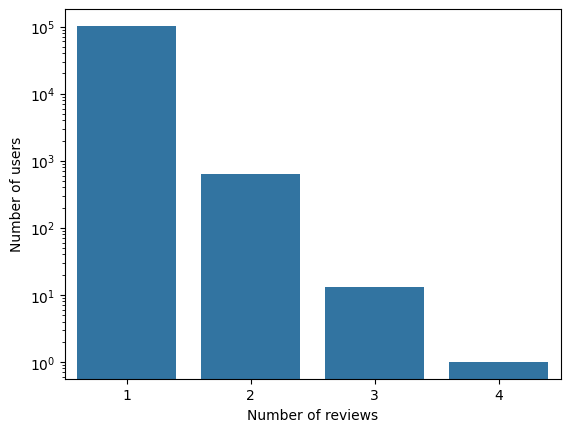

In [15]:
user_review_count_pd = user_review_count.toPandas()

# Only discrete values, log y-axis
sns.barplot(
    x=user_review_count_pd['review_count'],
    y=user_review_count_pd['user_count'],
    log=True
)
plt.xlabel('Number of reviews')
plt.ylabel('Number of users')

plt.show()

## Histogram of review_count

In [16]:
most_reviewed_games_pdf = most_reviewed_games.toPandas()

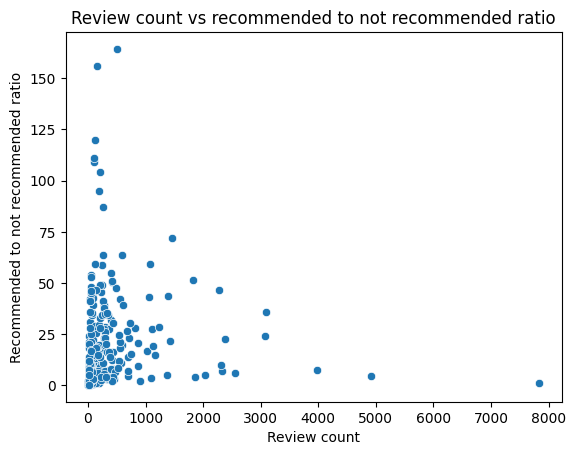

In [17]:
sns.scatterplot(
    x='review_count',
    y='recommended_to_not_recommended_ratio',
    data=most_reviewed_games_pdf
)

plt.xlabel('Review count')
plt.ylabel('Recommended to not recommended ratio')
plt.title('Review count vs recommended to not recommended ratio')
plt.show()

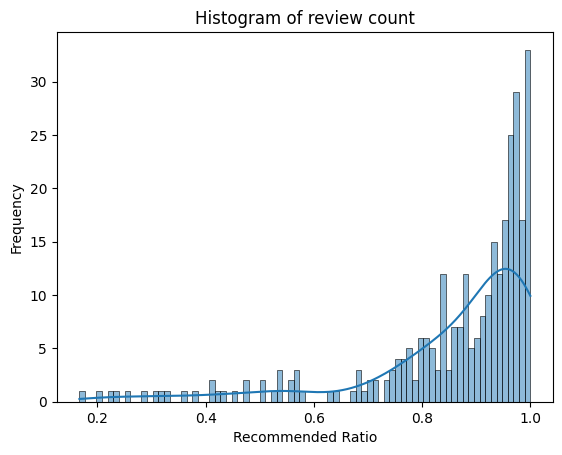

In [18]:
sns.histplot(
    most_reviewed_games_pdf['recommended_ratio'],
    bins=80,
    kde=True
)
plt.xlabel('Recommended Ratio')
plt.ylabel('Frequency')
plt.title('Histogram of review count')
plt.show()

In [19]:
game_reviews\
    .filter(game_reviews.author_steamid > 100)\
    .groupBy(game_reviews.app_id, game_reviews.author_steamid)\
    .agg(
        F.count('review_id').alias('review_count'),
    )\
    .orderBy(F.desc('review_count'))\
    .show(
        5
    )

+-------+-----------------+------------+
| app_id|   author_steamid|review_count|
+-------+-----------------+------------+
| 367520|76561198988312667|           2|
| 227300|76561198079793673|           2|
| 779340|76561198156707503|           1|
| 779340|76561198022192588|           1|
|1190460|76561198080232836|           1|
+-------+-----------------+------------+
only showing top 5 rows



# Collaborative filtering

+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------